In [1]:
import logging
import re

import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import numpy as np
from datamaestro import prepare_dataset
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from sklearn.metrics import accuracy_score

from tp10 import DatasetTP9, get_imdb_data
from tp10 import InfiniteLoader, train, get_prediction, get_all_prediction
from tp10 import Contextualiser, PositionalEncoding, TransformerQ1Q2, TransformerQ3, Transformer

In [2]:
word2id, embeddings, train_dataset, test_dataset = get_imdb_data()
id2word = {value:key for key,value in word2id.items() }

In [3]:
def collate_fn(samples):

    global word2id
    PAD_IX = word2id["__PAD__"]
    lenMax = np.max([len(e) for e, _ in samples])
    res = []
    targets = []

    for sample, target in samples:
        pads = torch.full((lenMax-len(sample),), PAD_IX, dtype=torch.int)
        res.append(torch.cat((sample, pads), 0))
        targets.append(target)

    return torch.stack(res).long(), torch.tensor(targets)

## Création train_dataset sample

In [5]:
class SampleDataset(Dataset):

    def __init__(self, dataset, nb_sample):
        self.data = []
        indices = np.random.choice(len(train_dataset), size=nb_sample, replace=False)
        for ind in indices:
            self.data.append(dataset[ind])

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)



In [6]:
train_dataset_sample = SampleDataset(train_dataset, 200)
test_dataset_sample = SampleDataset(test_dataset, 200)

In [4]:
BATCH_SIZE = 16
train_loader = DataLoader(DatasetTP9(train_dataset), collate_fn=collate_fn, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(DatasetTP9(test_dataset), collate_fn=collate_fn, shuffle=True, batch_size=BATCH_SIZE)
criterion = nn.CrossEntropyLoss()
inputDim = 50

# Question 1

In [10]:
modelQ1 = TransformerQ1Q2(embeddings=embeddings, word2id=word2id, context_model=nn.Identity(), \
                       values_model=None, keys_model=None, query_model=None, L=3, mlp=None, classifier=None)

In [11]:
optimizer = torch.optim.Adam(params=modelQ1.parameters())
nb_step = 2000
nb_step_val = 50
interval_step_val = 100

train_lossQ1, test_lossQ1 = train(train_loader, test_loader, modelQ1, optimizer, criterion, \
                                        nb_step=nb_step, nb_step_val=nb_step_val, interval_step_val=interval_step_val,\
                                        verbose=True, path="checkpointQ1.pt", path_early_stopping="bestParamsQ1.pt")

Validation loss decreased (inf --> 0.694009).  Saving model ...
Validation loss decreased (0.694009 --> 0.582929).  Saving model ...
Validation loss decreased (0.582929 --> 0.535935).  Saving model ...
Validation loss decreased (0.535935 --> 0.459681).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (0.459681 --> 0.449387).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Validation loss decreased (0.449387 --> 0.398564).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20
EarlyStopping counter: 10 out of 20



In [13]:
resQ1 = get_all_prediction(modelQ1, train_loader, True)
accuracy_score(resQ1[1], resQ1[0])

0.80908

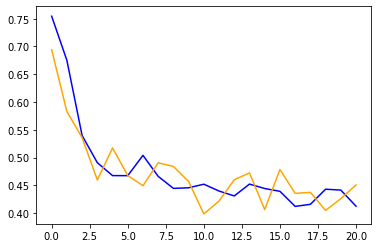

In [14]:
plt.plot(range(len(train_lossQ1)), train_lossQ1, color="blue")
plt.plot(range(len(test_lossQ1)), test_lossQ1, color="orange")

In [46]:
train_lossQ1

[0.5935570001602173,
 0.719457346200943,
 0.6864724695682526,
 0.694800740480423,
 0.7002190709114074,
 0.6956643462181091,
 0.6933189868927002,
 0.6929477632045746,
 0.68565514087677,
 0.6898543000221252,
 0.6880684494972229]

# Question 2

### Positionnal encoding

In [15]:
max_len = max([data.shape[1] for data,_ in train_loader])

In [16]:
modelQ2 = TransformerQ1Q2(embeddings=embeddings, word2id=word2id, context_model=nn.Identity(), \
                       values_model=None, keys_model=None, query_model=None, L=3, mlp=None, classifier=None, max_len=max_len)

In [17]:
optimizer = torch.optim.Adam(params=modelQ2.parameters())
nb_step = 2000
nb_step_val = 50
interval_step_val = 100

train_lossQ2, test_lossQ2 = train(train_loader, test_loader, modelQ2, optimizer, criterion, \
                                        nb_step=nb_step, nb_step_val=nb_step_val, interval_step_val=interval_step_val,\
                                        verbose=True, path="checkpointQ2.pt", path_early_stopping="bestParamsQ2.pt")

Validation loss decreased (inf --> 0.693537).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.693537 --> 0.683332).  Saving model ...
Validation loss decreased (0.683332 --> 0.628904).  Saving model ...
Validation loss decreased (0.628904 --> 0.529056).  Saving model ...
EarlyStopping counter: 1 out of 20
Validation loss decreased (0.529056 --> 0.488511).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Validation loss decreased (0.488511 --> 0.487432).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
Validation loss decreased (0.487432 --> 0.487327).  Saving model ...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
Validation loss decreased (0.487327 --> 0.472286).  Saving model ...
EarlyStopping counter: 1 out of 2

### Visualisation des produits scalaires des encodings

<AxesSubplot:>

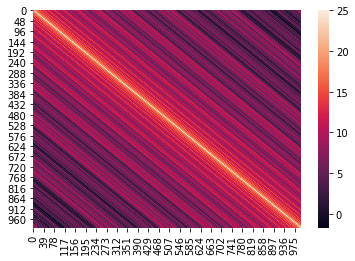

In [45]:
pe = PositionalEncoding(d_model=50, max_len=1000).pe[0]
sns.heatmap(pe.mm(pe.transpose(0,1)))

<AxesSubplot:>

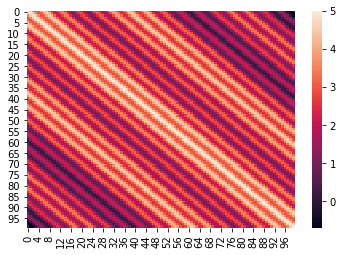

In [48]:
pe = PositionalEncoding(d_model=10, max_len=100).pe[0]
sns.heatmap(pe.mm(pe.transpose(0,1)))

<AxesSubplot:>

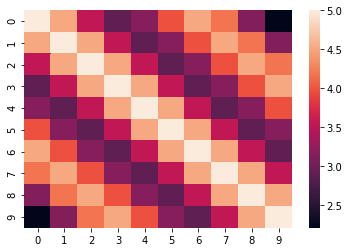

In [49]:
pe = PositionalEncoding(d_model=10, max_len=10).pe[0]
sns.heatmap(pe.mm(pe.transpose(0,1)))

# Question 3

In [58]:
modelQ3 = Transformer(embeddings=embeddings, word2id=word2id, context_model=None, \
                       values_model=None, keys_model=None, query_model=None, max_len=max_len)

optimizer = torch.optim.Adam(params=modelQ3.parameters(), lr=5e-3)
nb_step = 5
nb_step_val = 2

interval_step_val = 10

In [59]:
train_lossQ3, test_lossQ3 = train(train_loader, test_loader, modelQ3, optimizer, criterion, \
                                         nb_step=nb_step, nb_step_val=nb_step_val, interval_step_val=interval_step_val,\
                                         verbose=True, path="checkpointQ3.pt", path_early_stopping="bestParamsQ3.pt")

  0%|          | 0/5 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.696224).  Saving model ...
Validation loss decreased (0.696224 --> 0.695342).  Saving model ...
